# CESM Cleaning and Exploratory Data Analysis
Using our `pip`-installable `cesm` package, we perform a variety of cleaning and transformation procedures. These functions are written to be performed on all datasets at once, creating a dictionary of datasets.

## CESM Scenario Overview
**historical:** CMIP data from 1850-2014

_The remainder are SSP-based RCP scenarios with variable radiative forcing by the end of the century. These forcings, called "Representative Concentration Pathways", are concentration-driven and follow variable socioeconomic conditions. The numbers after "RCP" signify a specific level of radiative forcing reached in the year 2100, in terms of Watts per meter squared. (e.g., RCP4.5 represents $4.5 \frac{W}{m^{2}}$ of forcing in 2100)._ 

**ssp126:**  Low forcing, following approximately RCP2.6 global forcing pathway with SSP1 socioeconomic conditions.

**ssp245:**  Medium forcing, following approximately RCP4.5 global forcing pathway with SSP2 socioeconomic conditions.

**ssp370:**  Medium-high forcing, following approximately RCP7.0 global forcing pathway with SSP3 socioeconomic conditions.

**ssp585:**  High forcing, following approximately RCP8.5 global forcing pathway with SSP5 socioeconomic conditions.

## CESM Variable Definitions
[Link to full list of CMIP variables](https://clipc-services.ceda.ac.uk/dreq/index/var.html)

**huss:** Near-Surface Specific Humidity

**hurs:** Near-Surface Relative Humidity \[%\]

**pr:** Precipitation $[\frac{kg}{m^{2}s}]$

**tas:** Near-Surface Air Temperature \[K\]

**tasmin:** Daily Minimum Near-Surface Air Temperature \[K\]

**tasmax:** Daily Maximum Near-Surface Air Temperature \[K\]

In [1]:
# https://clipc-services.ceda.ac.uk/dreq/index.html
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature

## After pip install,
from cesm import cesm_analyze as ca

In [2]:
# Declare global variables
crs = ccrs.PlateCarree()  # set projection

vardict = {
    'huss': {'name': 'Specific Humidity', 'units': ''},
    'hurs': {'name': 'Relative Humidity', 'units': '[%]'},
    'pr': {'name': 'Precipitation', 'units': '$[\frac{kg}{m^{2}s}]$'},
    'tas': {'name': 'Air Temperature', 'units': 'K'},
    'tasmin': {'name': 'Daily Min. Air Temperature', 'units': 'K'},
    'tasmax': {'name': 'Daily Max. Air Temperature', 'units': 'K'},
}

modeldict = {
    'hist': {
        'code': 'historical', 'name': 'Historical Data'
    },
    'sp1': {
        'code': 'ssp126', 'name': r'$Scenario \#1: 2.6 \frac{W}{m^{2}}$'
    },
    'sp2': {
        'code': 'ssp245', 'name': r'$Scenario \#2: 4.5 \frac{W}{m^{2}}$'
    },
    'sp3': {
        'code': 'ssp370', 'name': r'$Scenario \#3: 7.0 \frac{W}{m^{2}}$'
    },
    'sp5': {
        'code': 'ssp585', 'name': r'$Scenario \#5: 8.5 \frac{W}{m^{2}}$'
    },
}

list(modeldict)

['hist', 'sp1', 'sp2', 'sp3', 'sp5']

In [3]:
ds = ca.dictorize(
    func = xr.open_zarr, 
    modeldict = {k: v['code'] for k, v in modeldict.items()},
)

print(f'Available datasets: {list(ds)}')
ds['hist']

Available datasets: ['hist', 'sp1', 'sp2', 'sp3', 'sp5']


<xarray.Dataset>
Dimensions:    (time: 1980, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    hurs       (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
    huss       (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    table_id:               Amon
    tracking_id:            hdl:21.14100/56114e92-8200-4e9f-b9d0-48580aeb8395...
    variable_id:            hurs
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1
    version_id:             v20190514

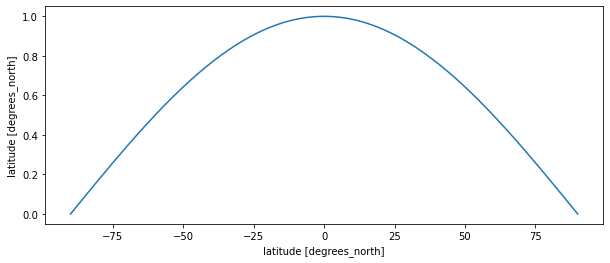

In [4]:
# Now, perform weighing to get true aggregate statistics
# 
# First, an example of weights by Earth's latitude
weights = np.cos(np.deg2rad(ds['hist']['lat']))
weights.name = 'weights'
weights.plot(figsize=(10, 4));

In [5]:
# Perform weighing on all datasets
ds_w = ca.dictorize(
    func = 'weight', 
    modeldict = ds,
)

ds_w['hist']

DatasetWeighted with weights along dimensions: lat

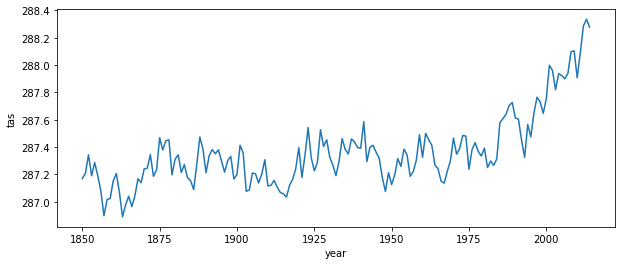

In [6]:
# Now look at global averages
# "_mt" for mean data at each time step (month)
ds_mt = ca.dictorize(
    func = 'agg',
    modeldict = ca.nest_dicts(
        ds_w,
         # in aggs, roll arg is required below (even if empty)
        {'grps': ('lat', 'lon'), 'aggfunc': np.nanmean, 'roll': {}},
    ),
)


# "_my" for mean of each year
ds_my = ca.dictorize(
    func = 'agg',
    modeldict = ca.nest_dicts(
        ds_mt,
         # in aggs, roll arg is required below (even if empty)
        {'grps': 'time.year', 'aggfunc': np.nanmean, 'roll': {}},
    ),
)

# Plot air surface temperature over recorded period in history
ds_my['hist']['tas'].plot(figsize=(10,4));

So 1850 - ~1980 may be more appropriate for historical average comparisons.

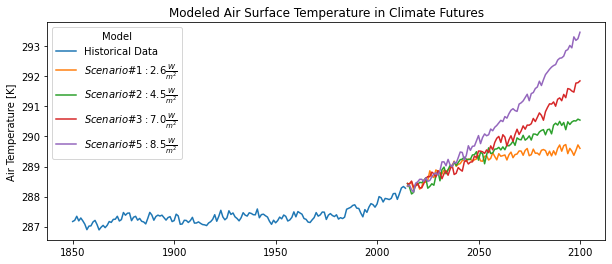

In [7]:
# Now, let's look at past vs. future for air temperatures!

param = 'tas' # for air temperatures of air at the surface 

fig, ax = plt.subplots(figsize=(10, 4))

for model in ds_my.keys():
    ds_my[model][param].plot(ax=ax, label=modeldict[model]['name'])

ax.set_xlabel('')
ax.set_ylabel(f"{vardict[param]['name']} [{vardict[param]['units']}]")
ax.set_title('Modeled Air Surface Temperature in Climate Futures')
ax.legend(title="Model");

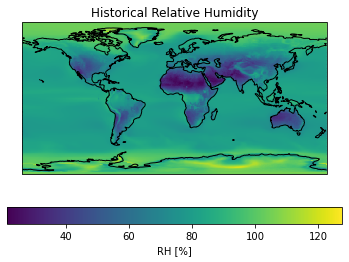

In [26]:
# Calculate baselines from subset of raw data
baseline = (
    ds['hist']
    .sel(time=slice('1850', '1980'))
    .mean('time')
)

# Plot on a map
ax = plt.subplot(projection=crs)
baseline['hurs'].plot(
    ax=ax, transform=crs,
    cbar_kwargs={
        'orientation': 'horizontal',
        'label': 'RH [%]',
    }
)

# Add coastlines and format
ax.coastlines("110m", color="k")
ax.set_title('Historical Relative Humidity');

In [ ]:
diffs = {}

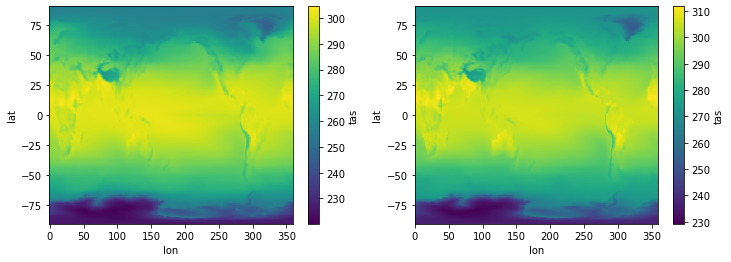

In [7]:
# Plot temp diff between historical average and worst-case at 2100
## Note diff in legends!
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

hist_w.mean('time')['tas'].plot(ax=ax[0])
sp5.sel(time='2100').weighted(weights).mean('time')['tas'].plot(ax=ax[1]);

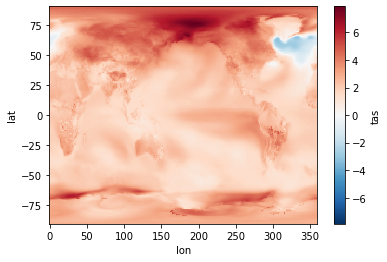

In [8]:
# def view_outcomes(models, param, date): 
#     """
#     """
#     d = {
#         'hist': hist_w.mean('time')['tas'],
#         'sp1': sp1.sel(time=str(date)).weighted(weights).mean('time')['tas'],
#     }

pre = hist_w.mean('time')['tas']
post5 = sp1.sel(time=str('2100')).weighted(weights).mean('time')['tas']

# models_weighted
# models_raw = [hist, sp1, sp2, sp3, sp5]
# model_names = ['hist', 'sp1', 'sp2', 'sp3', 'sp5']

# units = {
#     'huss': '',
#     'hurs': '[%]',
#     'pr': '$[\frac{kg}{m^{2}s}]$',
#     'tas': 'K',
#     'tasmin': 'K',
#     'tasmax': 'K',
# }

(post5-pre).plot();

In [9]:
# cbar_kwargs={
#             # "orientation": "horizontal",
#             'anchor': (0.5, -0.15),
#             "shrink": 0.8,
#             "aspect": 20,
#             'label': 'ΔSST (°C)',
#             'ticks': [-2, 0, 2],
#             'spacing': 'proportional',
#         },

# crs = ccrs.PlateCarree()  # set projection

# # Plot on a map
# ax = plt.subplot(projection=crs)
# subset.analysed_sst[0, :, :].plot(ax=ax, transform=crs)
# ax.coastlines("10m", color="k")
# ax.add_feature(cfeature.LAND, color="grey")
# ax.add_feature(cfeature.STATES.with_scale("10m"))

In [10]:
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
s_names = [i[1:4] for i in scenarios]
model_names = ['hist'] + s_names
model_names

['hist', 'sp1', 'sp2', 'sp3', 'sp5']

In [11]:
dict(zip(model_names, ['historical']+scenarios))

{'hist': 'historical',
 'sp1': 'ssp126',
 'sp2': 'ssp245',
 'sp3': 'ssp370',
 'sp5': 'ssp585'}

In [12]:
def agg_ds(ds, aggfunc, dims, roll={}):
    """
    """
    if isinstance(ds, xr.core.weighted.DatasetWeighted):
        ds_agg = ds.mean(('lat', 'lon'))
    else:
        ds_agg = ds.copy()

    if len(roll.keys()) > 0:
        ds_agg = ds_agg.roll(roll)
    else:
        if isinstance(dims, str):
            ds_agg = ds_agg.groupby(dims).reduce(aggfunc)
        else:
            ds_agg = ds_agg.reduce(aggfunc, dims)
    
    return ds_agg

In [13]:
def dictorize(func, modeldict):
    """
    performs a function on all provided 
    xarray datasets.
    inputs:
        - func: function or str of desired func.
            - options are:
                - xr.open_zarr
                - 'weight' for ds.weighted
                - 'sel' for ds.sel(...)
                - 'agg' for ds.groupby(...).agg(...)
                - 'var' for ds[var]
        ##- models: list of model names
        - modeldict: dictionary of format
            - key: model names (informal)
            - values: str or dictionary of values
                      to pass to func. Specific to
                      each func. If dataset provided,
                      use key['data'] as storage location.
                - values with unnested dict:
                    - [xr.open_zarr, 'weight']
                - values with nested dict:
                    - [all others]
    output:
        - dictionary of xarray datasets
        - dict will be of xarray dataarrays if 'var' func is used
    """
    if func==xr.open_zarr:
        d = {
            k: func(f'cmip_data/{v}.zarr') for k, v in modeldict.items()
        }

    if func=='sel':
        d = {
            k: v['data'].sel(
                v['args']
            ) for k, v in modeldict.items()
        }

    if func=='var':
        d = {
            k: ds['data'][ds['var']] for k, ds in modeldict.items()
        }

    if func=='weight':
        keys = list(modeldict)
        first_ds = modeldict[keys[0]]#['data']

        weights = np.cos(np.deg2rad(first_ds['lat']))
        weights.name = 'weights'

        d = {
            k: ds.weighted(weights) for k, ds in modeldict.items()
        }

    if func=='agg':
        d = {}

        for k, v in modeldict.items():
            ds_temp = agg_ds(
                v['data'], 
                v['aggfunc'], v['grps'],
                v['roll'],
            )
            d[k] = ds_temp.copy()

    return d

In [14]:
def nest_dicts(d, d_args={}):
    """
    take output from dictorize() and
    nest (sometimes with additional args)
    for input into dictorize() again.
    inputs:
        - d: dict of xarray datasets
             (directly output from dictorize() )
        - d_args: dict, additional args to add
            - can be nested dict of k[arg] = val
            - can be unnested dict of {arg: val}
                (if so, will be broadcast to all ds in d)
    output:
        - nested dict of xarray datasets and
          associated args for input into dictorize()
            - dataset under k['data']
            - args under k[...]
    """
    dn = {}
    for k in d.keys():
        dn[k] = {}

    for k, v in d.items():
        dn[k]['data'] = v

    if len(d_args.keys()) > 0:
        same_keys = set(list(d)) == set(list(d_args))
        
        if not same_keys:
            # then assume d_args is for all ds in d,
            # and nest
            
            # create new dict
            d_args_old = {
                argk: argv for argk, argv in d_args.items()
            }
            d_args = {}
            
            # replace input dict
            for k in d.keys():
                d_args[k] = {}
                for argk, argv in d_args_old.items():
                    d_args[k][argk] = argv

        # Proceed with d_args as nested dict (from input or transform)
        for k, args in d_args.items():
            for arg_key, arg_val in args.items():
                dn[k][arg_key] = arg_val

    return dn

In [17]:
dtest = dictorize(
    func = xr.open_zarr, 
    modeldict = dict(zip(model_names, ['historical']+scenarios)),
)
###########################################################################
# dtest_w = dictorize(
#     func = 'weight', 
#     modeldict = dtest,
# )
###########################################################################
# dtest_s = dictorize(
#     func = 'sel',
#     modeldict = nest_dicts(
#         dtest, 
#         ##{k: {'args': {'lat': slice(0, 20)}} for k in model_names},
#         {'args': {'lat': slice(0, 20)}},
#     ),
# )
###########################################################################
# dtest_v = dictorize(
#     func = 'var',
#     modeldict = nest_dicts(
#         dtest, 
#         {'var': 'tas'},
#     ),
# )
###########################################################################
# dtest_a = dictorize(
#     func = 'agg',
#     modeldict = nest_dicts(
#         dtest,
#         {'grps': ['lat', 'lon'], 'aggfunc': np.nanmean, 'roll': {}},
#     ),
# )
###########################################################################
# dtest_a1 = dictorize(
#     func = 'agg',
#     modeldict = nest_dicts(
#         dtest,
#         {'grps': 'time.year', 'aggfunc': np.nanmean, 'roll': {}},
#     ),
# )
###########################################################################
# dtest_a2 = dictorize(
#     func = 'agg',
#     modeldict = nest_dicts(
#         dtest_w,
#         {'grps': 'time.year', 'aggfunc': np.nanmean, 'roll': {}},
#     ),
# )
###########################################################################
# dtest_a3 = dictorize(
#     func = 'agg',
#     modeldict = nest_dicts(
#         dtest,
#         {'grps': ['lat', 'lon'], 'aggfunc': np.nanmean, 'roll': {}},
#     ),
# )
###########################################################################
dtest_a4 = dictorize(
    func = 'agg',
    modeldict = nest_dicts(
        dtest,
        {'grps': ['lat', 'lon'], 'aggfunc': np.nanmean, 'roll': {'time': 120}}, # time only works in original units
    ),
)
###########################################################################
print(dtest_a4.keys())
dtest_a4['hist']

dict_keys(['hist', 'sp1', 'sp2', 'sp3', 'sp5'])


<xarray.Dataset>
Dimensions:    (time: 1980, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    hurs       (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
    huss       (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    table_id:               Amon
    tracking_id:            hdl:21.14100/56114e92-8200-4e9f-b9d0-48580aeb8395...
    variable_id:            hurs
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1
    version_id:             v20190514